# Floresta Aleatória
**Variáveis Desagregadas (2018-2024)** \\
 \\
Bootcamp Machine Learning ENAP 2024 \\
Maurício Marques Soares Filho \\
25/10/2024 \\

## Imports...

In [46]:
!pip install dtreeviz
!pip install scikit-optimize

In [47]:
###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dtreeviz

###
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.inspection import permutation_importance

###
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

###
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV

###
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier


###
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV

###
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Pré-processamento dos dados

In [48]:
#Estilizar conteúdo
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

def estilo_tabelas(df, max_altura = '300px', casas_decimais = 3):
    return (
        df.style.set_table_styles(
            [
                {'selector': 'thead th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('border-bottom', '2px solid #007BFF')]},
                {'selector': 'td', 'props': [('font-size', '10px'), ('text-align', 'center'), ('max-height', '40px'), ('white-space', 'nowrap'), ('text-overflow', 'ellipsis'), ('overflow', 'hidden'), ('max-width', '100px')]},
                {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
                {'selector': 'table', 'props': [('width', '90%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]},
                {'selector': 'td, th', 'props': [('border', '1px solid #666')]},  # Bordas cinza escuro
            ]
        ).set_properties(
            **{'border-color': 'darkgray', 'border-style': 'solid', 'border-width': '1px'}
        ).set_table_attributes(
            f'style = "height:auto; overflow:auto; max-height:{max_altura}; display:block;"'
        ).format(
            precision=casas_decimais
        )
    )

In [49]:
# Importar a base de dados
df_eventos_2018_2024_modelo2 = pd.read_csv(
     "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_2018_2024_modelo2.csv",
    sep = ';',
    decimal = ',',
)

estilo_tabelas(df_eventos_2018_2024_modelo2.head(5))

,Status,DH_MORTOS,DH_FERIDOS,DH_ENFERMOS,DH_DESABRIGADOS,DH_DESALOJADOS,DH_DESAPARECIDOS,DH_OUTROS AFETADOS,DM_Uni Habita Danificadas,DM_Uni Habita Destruidas,DM_Uni Habita Valor,DM_Inst Saúde Danificadas,DM_Inst Saúde Destruidas,DM_Inst Saúde Valor,DM_Inst Ensino Danificadas,DM_Inst Ensino Destruidas,DM_Inst Ensino Valor,DM_Inst Serviços Danificadas,DM_Inst Serviços Destruidas,DM_Inst Serviços Valor,DM_Inst Comuni Danificadas,DM_Inst Comuni Destruidas,DM_Inst Comuni Valor,DM_Obras de Infra Danificadas,DM_Obras de Infra Destruidas,DM_Obras de Infra Valor,PEPL_Assis_méd e emergên(R$),PEPL_Abast de água pot(R$),PEPL_sist de esgotos sanit(R$),PEPL_Sis limp e rec lixo (R$),PEPL_Sis cont pragas (R$),PEPL_distrib energia (R$),PEPL_Telecomunicações (R$),PEPL_Tran loc/reg/l_curso (R$),PEPL_Distrib combustíveis(R$),PEPL_Segurança pública (R$),PEPL_Ensino (R$),PEPR_Agricultura (R$),PEPR_Pecuária (R$),PEPR_Indústria (R$),PEPR_Comércio (R$),PEPR_Serviços (R$),DensidadePop,DOMICILIO_AREARURAL,PDEFAGUA,PDEFESGOTO,PDEFLIXO,PDEFSAN,QTDE_FAMILIAS_ATUALIZADAS,Sigla_UF_AC,Sigla_UF_AL,Sigla_UF_AM,Sigla_UF_AP,Sigla_UF_BA,Sigla_UF_CE,Sigla_UF_DF,Sigla_UF_ES,Sigla_UF_GO,Sigla_UF_MA,Sigla_UF_MG,Sigla_UF_MS,Sigla_UF_MT,Sigla_UF_PA,Sigla_UF_PB,Sigla_UF_PE,Sigla_UF_PI,Sigla_UF_PR,Sigla_UF_RJ,Sigla_UF_RN,Sigla_UF_RO,Sigla_UF_RR,Sigla_UF_RS,Sigla_UF_SC,Sigla_UF_SE,Sigla_UF_SP,Sigla_UF_TO,Sigla_UF_pa,COBRADE_11110,COBRADE_11120,COBRADE_11311,COBRADE_11312,COBRADE_11313,COBRADE_11321,COBRADE_11331,COBRADE_11332,COBRADE_11340,COBRADE_11410,COBRADE_11420,COBRADE_11431,COBRADE_11432,COBRADE_11433,COBRADE_12100,COBRADE_12200,COBRADE_12300,COBRADE_13111,COBRADE_13112,COBRADE_13120,COBRADE_13211,COBRADE_13212,COBRADE_13213,COBRADE_13214,COBRADE_13215,COBRADE_13310,COBRADE_13321,COBRADE_13322,COBRADE_14110,COBRADE_14120,COBRADE_14131,COBRADE_14132,COBRADE_14140,COBRADE_15110,COBRADE_15120,COBRADE_15130,COBRADE_15210,COBRADE_15230,COBRADE_22210,COBRADE_22220,COBRADE_23120,COBRADE_24100,COBRADE_24200,COBRADE_25100,COBRADE_25500
0,1,0,0,0,0,0,0,11650,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,132466.926,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,264933.852,309089.494,58874.189,228137.484,0.000,134.493,0.305,0.191,0.559,0.167,0.091,383.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1,0,0,0,0,0,0,2548,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,103709.315,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5905738.840,603420.207,0.000,0.000,0.000,10.669,0.632,0.246,0.456,0.175,0.070,57.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0,0,180,0,0,156,0,0,112,0,515149.157,0.000,0,0.000,0.000,0,0.000,0,0,0.000,1,0,161904.021,16.000,0.000,1619040.208,161904.021,0.000,0.000,1766225.681,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,0.708,0.691,0.851,0.691,0.576,356.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000

In [54]:
# Remover linhas com dados ausentes
df_eventos_2018_2024_modelo2 = df_eventos_2018_2024_modelo2.dropna()
estilo_tabelas(df_eventos_2018_2024_modelo2.head(5))

# Remover linhas com todos os dados informados = 0.
colunas_informados = [
    'DH_MORTOS', 'DH_FERIDOS', 'DH_ENFERMOS', 'DH_DESABRIGADOS', 'DH_DESALOJADOS',
    'DH_DESAPARECIDOS', 'DH_OUTROS AFETADOS',
    'DM_Uni Habita Danificadas', 'DM_Uni Habita Destruidas', 'DM_Uni Habita Valor',
    'DM_Inst Saúde Danificadas', 'DM_Inst Saúde Destruidas', 'DM_Inst Saúde Valor',
    'DM_Inst Ensino Danificadas', 'DM_Inst Ensino Destruidas', 'DM_Inst Ensino Valor',
    'DM_Inst Serviços Danificadas', 'DM_Inst Serviços Destruidas', 'DM_Inst Serviços Valor',
    'DM_Inst Comuni Danificadas', 'DM_Inst Comuni Destruidas', 'DM_Inst Comuni Valor',
    'DM_Obras de Infra Danificadas', 'DM_Obras de Infra Destruidas', 'DM_Obras de Infra Valor',
    'PEPL_Assis_méd e emergên(R$)', 'PEPL_Abast de água pot(R$)',
    'PEPL_sist de esgotos sanit(R$)', 'PEPL_Sis limp e rec lixo (R$)', 'PEPL_Sis cont pragas (R$)',
    'PEPL_distrib energia (R$)', 'PEPL_Telecomunicações (R$)', 'PEPL_Tran loc/reg/l_curso (R$)',
    'PEPL_Distrib combustíveis(R$)', 'PEPL_Segurança pública (R$)', 'PEPL_Ensino (R$)',
    'PEPR_Agricultura (R$)', 'PEPR_Pecuária (R$)', 'PEPR_Indústria (R$)', 'PEPR_Comércio (R$)',
    'PEPR_Serviços (R$)'
]

df_eventos_2018_2024_modelo2 = df_eventos_2018_2024_modelo2[
    ~(df_eventos_2018_2024_modelo2[colunas_informados] == 0).all(axis=1)
]

In [55]:
# Dimensões do dataset
status_counts = df_eventos_2018_2024_modelo2['Status'].value_counts()
print("\nContagem da variável 'Status':")
status_counts.index=['Reconhecido', 'Não Reconhecido']
display(status_counts)


Contagem da variável 'Status':


,count
Reconhecido,7380
Não Reconhecido,590


## Modelo Sem Balanceamento

In [56]:
# Divisão em Dados de Treino e Teste
df_eventos_2018_2024_modelo2 = df_eventos_2018_2024_modelo2.sample(frac = 1, random_state = 42).reset_index(drop = True, inplace = False)
X_2018_2024_modelo2 = df_eventos_2018_2024_modelo2.drop('Status', axis = 1)
y_2018_2024_modelo2 = df_eventos_2018_2024_modelo2['Status']
X_train_2018_2024_modelo2, X_test_2018_2024_modelo2, y_train_2018_2024_modelo2, y_test_2018_2024_modelo2 = train_test_split(X_2018_2024_modelo2, y_2018_2024_modelo2, test_size = 0.2, random_state = 42, stratify = y_2018_2024_modelo2)

# Dimensões do dataset de treino
status_counts = y_train_2018_2024_modelo2.value_counts()
print("\nDimensões do dataset de treino:")
status_counts.index=['Reconhecido', 'Não Reconhecido']
display(status_counts)

# Dimensões do dataset de teste
status_counts = y_test_2018_2024_modelo2.value_counts()
print("\nDimensões do dataset de teste:")
status_counts.index=['Reconhecido', 'Não Reconhecido']
display(status_counts)


Dimensões do dataset de treino:


,count
Reconhecido,5904
Não Reconhecido,472



Dimensões do dataset de teste:


,count
Reconhecido,1476
Não Reconhecido,118


In [57]:
# Treinamento

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'rf_class_0__criterion': ['gini', 'entropy'],
    'rf_class_0__n_estimators': [150, 175, 200, 225, 250, 300],
    'rf_class_0__max_depth': [2, 4, 6, 8],
    'rf_class_0__min_samples_split': [2, 5, 10, 15, 100],
    'rf_class_0__min_samples_leaf': [1, 2, 5, 10],
    'rf_class_0__max_features': ['sqrt', 'log2', None]
}

# Criar pipeline com RobustScaler e RandomForestClassifier
pipeline_rf_class_0 = Pipeline([
    ('scaler', RobustScaler()),
    ('rf_class_0', RandomForestClassifier(random_state = 42))
])

# Realizar a busca bayesiana com validação cruzada
bayes_search_rf_class_0 = BayesSearchCV(
    pipeline_rf_class_0,
    search_spaces = param_grid_bayes,
    n_iter = 30,
    cv = 5,
    scoring = 'f1_weighted',
    n_jobs = -1,
    random_state = 42
)

# Ajustar a busca bayesiana ao conjunto de treino
bayes_search_rf_class_0.fit(X_train_2018_2024_modelo2, y_train_2018_2024_modelo2)

# Melhor modelo encontrado
best_rf_class_0_model = bayes_search_rf_class_0.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros: {bayes_search_rf_class_0.best_params_}")

# Fazer previsões com o conjunto de teste
y_pred_rf_class_0 = best_rf_class_0_model.predict(X_test_2018_2024_modelo2)

# Relatório de classificação TREINO
classification_report_rf_class_0 = metrics.classification_report(y_train_2018_2024_modelo2, best_rf_class_0_model.predict(X_train_2018_2024_modelo2), digits = 6, target_names = ['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest [TREINO]: \n')
print(classification_report_rf_class_0)

# Relatório de classificação TESTE
classification_report_rf_class_0 = metrics.classification_report(y_test_2018_2024_modelo2, y_pred_rf_class_0, digits = 6, target_names = ['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest [TESTE]: \n')
print(classification_report_rf_class_0)

Melhores hiperparâmetros: OrderedDict([('rf_class_0__criterion', 'gini'), ('rf_class_0__max_depth', 8), ('rf_class_0__max_features', None), ('rf_class_0__min_samples_leaf', 2), ('rf_class_0__min_samples_split', 2), ('rf_class_0__n_estimators', 225)])

 Classification report para Random Forest [TREINO]: 

                 precision    recall  f1-score   support

Não reconhecido   1.000000  0.273305  0.429285       472
    Reconhecido   0.945094  1.000000  0.971772      5904

       accuracy                       0.946205      6376
      macro avg   0.972547  0.636653  0.700528      6376
   weighted avg   0.949158  0.946205  0.931613      6376


 Classification report para Random Forest [TESTE]: 

                 precision    recall  f1-score   support

Não reconhecido   0.863636  0.161017  0.271429       118
    Reconhecido   0.937023  0.997967  0.966535      1476

       accuracy                       0.936010      1594
      macro avg   0.900330  0.579492  0.618982      1594
   weigh

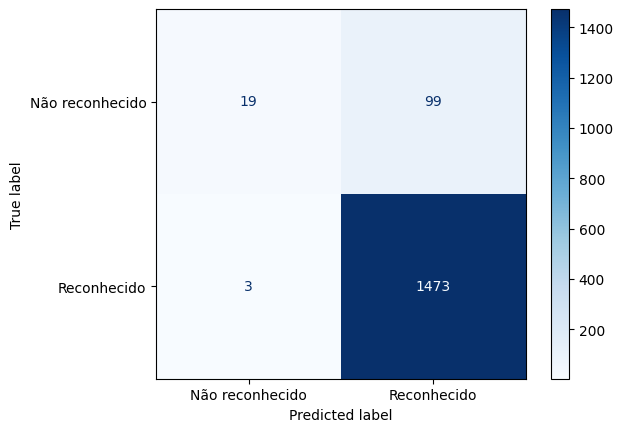

In [59]:
# Matriz de Confusão
ConfusionMatrixDisplay.from_estimator(best_rf_class_0_model, X_test_2018_2024_modelo2, y_test_2018_2024_modelo2, values_format='d', cmap='Blues', display_labels=['Não reconhecido', 'Reconhecido'])

## Balanceamento de Dados com SMOTE

In [60]:
# Divisão em Dados de Treino e Teste
X_smote = df_eventos_2018_2024_modelo2.drop('Status', axis=1)
y_smote = df_eventos_2018_2024_modelo2['Status']
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size = 0.2, random_state = 42, stratify = y_smote)

In [61]:
# Aplicar SMOTE apenas no conjunto de treino
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_smote, y_train_smote)

In [62]:
# Treinamento

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'rf_class_1__criterion': ['gini', 'entropy'],
    'rf_class_1__n_estimators': [150, 175, 200, 225, 250, 300],
    'rf_class_1__max_depth': [2, 4, 6, 8],
    'rf_class_1__min_samples_split': [2, 5, 10, 15, 100],
    'rf_class_1__min_samples_leaf': [1, 2, 5, 10],
    'rf_class_1__max_features': ['sqrt', 'log2', None]
}

# Criar pipeline com RobustScaler e RandomForestClassifier
pipeline_rf_class_1 = Pipeline([
    ('scaler', RobustScaler()),
    ('rf_class_1', RandomForestClassifier(random_state = 42))
])

# Realizar a busca bayesiana com validação cruzada
bayes_search_rf_class_1 = BayesSearchCV(
    pipeline_rf_class_1,
    search_spaces = param_grid_bayes,
    n_iter = 30,
    cv = 5,
    scoring = 'f1_weighted',
    n_jobs = -1,
    random_state = 42
)

# Ajustar a busca bayesiana ao conjunto de treino
bayes_search_rf_class_1.fit(X_train_smote, y_train_smote)

# Melhor modelo encontrado
best_rf_class_1_model = bayes_search_rf_class_1.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros: {bayes_search_rf_class_1.best_params_}")

# Fazer previsões com o conjunto de teste
y_pred_rf_class_1 = best_rf_class_1_model.predict(X_test_smote)

# Relatório de classificação TREINO
classification_report_rf_class_1 = metrics.classification_report(y_train_smote, best_rf_class_1_model.predict(X_train_smote), digits = 6, target_names = ['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest com SMOTE [TREINO]: \n')
print(classification_report_rf_class_1)


# Relatório de classificação TESTE
classification_report_rf_class_1 = metrics.classification_report(y_test_smote, y_pred_rf_class_1, digits = 6, target_names = ['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest com SMOTE [TESTE]: \n')
print(classification_report_rf_class_1)

Melhores hiperparâmetros: OrderedDict([('rf_class_1__criterion', 'gini'), ('rf_class_1__max_depth', 8), ('rf_class_1__max_features', None), ('rf_class_1__min_samples_leaf', 1), ('rf_class_1__min_samples_split', 10), ('rf_class_1__n_estimators', 250)])

 Classification report para Random Forest com SMOTE [TREINO]: 

                 precision    recall  f1-score   support

Não reconhecido   0.950244  0.921917  0.935867      5904
    Reconhecido   0.924178  0.951728  0.937750      5904

       accuracy                       0.936822     11808
      macro avg   0.937211  0.936822  0.936808     11808
   weighted avg   0.937211  0.936822  0.936808     11808


 Classification report para Random Forest com SMOTE [TESTE]: 

                 precision    recall  f1-score   support

Não reconhecido   0.423358  0.491525  0.454902       118
    Reconhecido   0.958819  0.946477  0.952608      1476

       accuracy                       0.912798      1594
      macro avg   0.691089  0.719001  0.7037

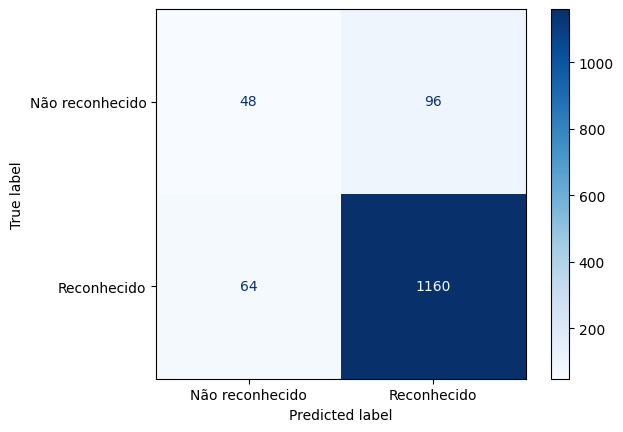

In [13]:
# Matriz de Confusão
ConfusionMatrixDisplay.from_estimator(best_rf_class_1_model, X_test_smote, y_test_smote, values_format='d', cmap='Blues', display_labels=['Não reconhecido', 'Reconhecido'])

## Avaliação das Variáveis de Importância
Avaliação das variáveis de importância de acordo com o modelo desbalanceado,  que apresentou o maior f1-score.

In [63]:
# Passo intermediário
X_train     = X_train_2018_2024_modelo2
y_train     = y_train_2018_2024_modelo2
X_test      = X_test_2018_2024_modelo2
y_test      = y_test_2018_2024_modelo2
model_type  = 'rf_class_0'
best_model  = best_rf_class_0_model

# Ajustar o melhor modelo encontrado (depois da busca bayesiana)
best_model.named_steps[model_type].fit(X_train, y_train)

# Obter a importância das features
importance_dict = {}
for feature, importance in zip(X_train.columns, best_model.named_steps[model_type].feature_importances_):
    importance_dict[feature] = importance
#importance_dict

# Transformar em DataFrame para organizar como tabela
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
})

# Ordenar pela importância em ordem decrescente
importance_df = importance_df.sort_values(by = 'Importance', ascending = False)
estilo_tabelas(importance_df.head(10))

,Feature,Importance
11,DM_Inst Saúde Destruidas,0.273
6,DH_OUTROS AFETADOS,0.113
7,DM_Uni Habita Danificadas,0.075
8,DM_Uni Habita Destruidas,0.042
36,PEPR_Agricultura (R$),0.030
47,QTDE_FAMILIAS_ATUALIZADAS,0.029
23,DM_Obras de Infra Destruidas,0.024
41,DensidadePop,0.022
26,PEPL_Abast de água pot(R$),0.019
42,DOMICILIO_AREARURAL,0.018


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names


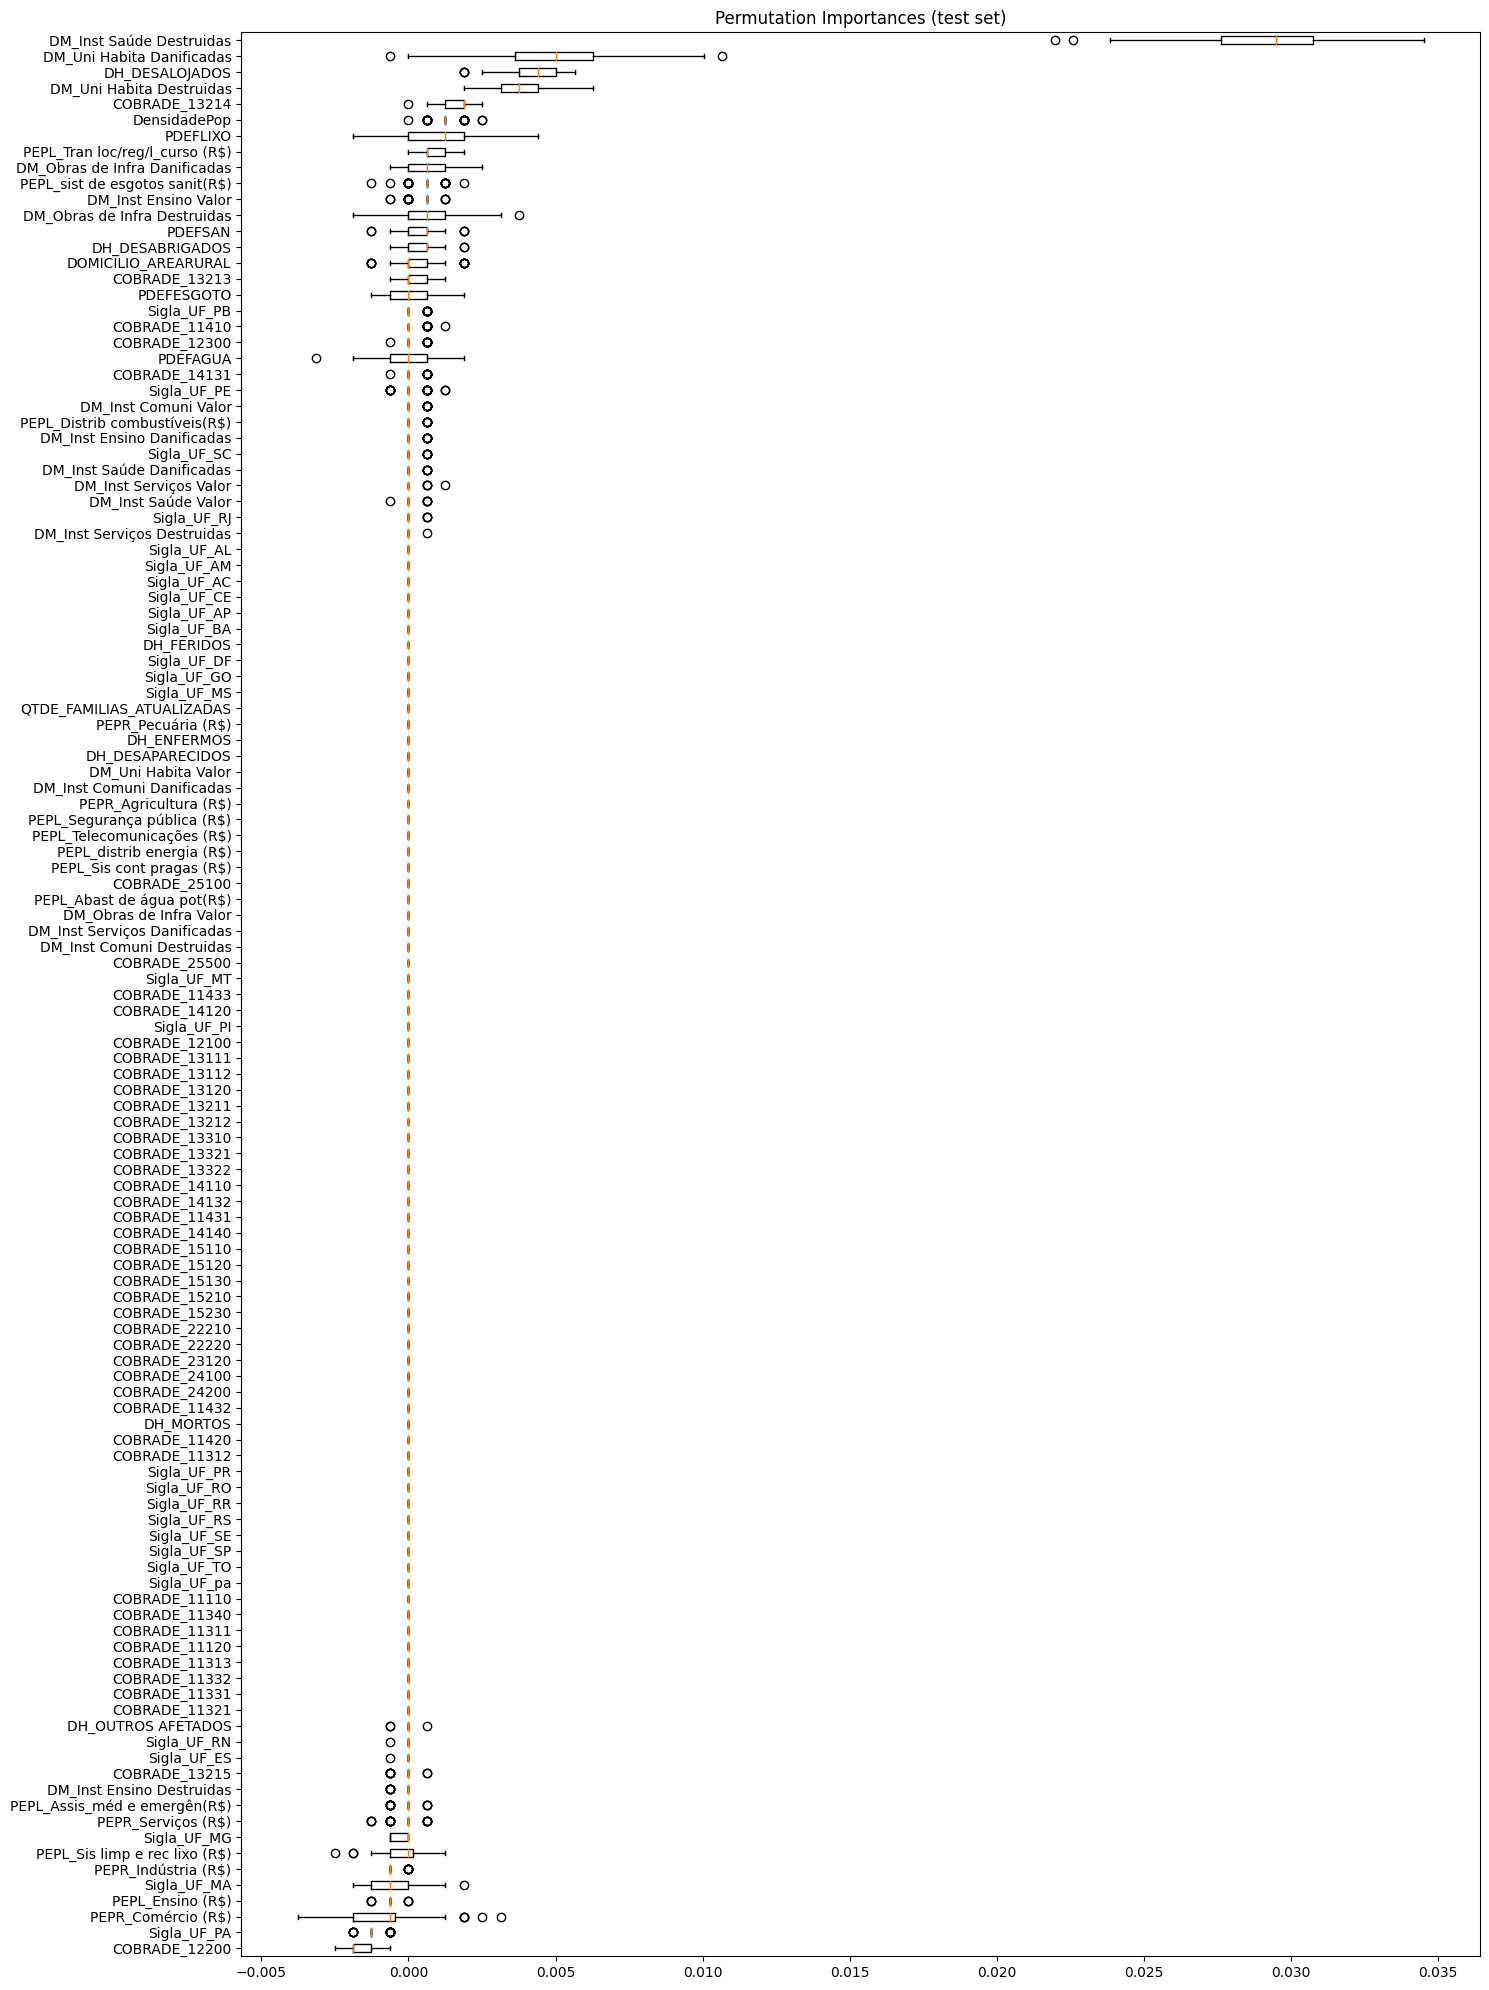

In [64]:
# Calcular os resultados (permutation_importance) da queda no desempenho do modelo ao embaralhar cada uma das variáveis.
result = permutation_importance(best_model, X_test, y_test, n_repeats = 100, random_state = 42, n_jobs = -1)

# Ordenar os resultados
sorted_idx = result.importances_mean.argsort()

# Gráfico boxplot pra mostrar a importância das variáveis
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert = False, labels = X_test.columns[sorted_idx])
ax.set_title('Permutation Importances (test set)')
fig.set_size_inches(15, 20)
fig.tight_layout()
plt.show()

## Seleção de Variáveis

### Importância Média > 0.00

In [65]:
# Filtrar as variáveis com importância média > 0
positive_idx = result.importances_mean > 0.0

# Selecionar apenas as colunas das features com importância positiva
selected_features = X_test.columns[positive_idx]

# Criar novos datasets apenas com essas features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Exibir as features selecionadas
print('Número de Features:', len(selected_features))
print('Features selecionadas:', selected_features.tolist())

Número de Features: 32
Features selecionadas: ['DH_DESABRIGADOS', 'DH_DESALOJADOS', 'DM_Uni Habita Danificadas', 'DM_Uni Habita Destruidas', 'DM_Inst Saúde Danificadas', 'DM_Inst Saúde Destruidas', 'DM_Inst Saúde Valor', 'DM_Inst Ensino Danificadas', 'DM_Inst Ensino Valor', 'DM_Inst Serviços Destruidas', 'DM_Inst Serviços Valor', 'DM_Inst Comuni Valor', 'DM_Obras de Infra Danificadas', 'DM_Obras de Infra Destruidas', 'PEPL_sist de esgotos sanit(R$)', 'PEPL_Tran loc/reg/l_curso (R$)', 'PEPL_Distrib combustíveis(R$)', 'DensidadePop', 'DOMICILIO_AREARURAL', 'PDEFAGUA', 'PDEFESGOTO', 'PDEFLIXO', 'PDEFSAN', 'Sigla_UF_PB', 'Sigla_UF_PE', 'Sigla_UF_RJ', 'Sigla_UF_SC', 'COBRADE_11410', 'COBRADE_12300', 'COBRADE_13213', 'COBRADE_13214', 'COBRADE_14131']


In [66]:
# Treinamento

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'rf_class_0__criterion': ['gini', 'entropy'],
    'rf_class_0__n_estimators': [150, 175, 200, 225, 250, 300],
    'rf_class_0__max_depth': [2, 4, 6, 8],
    'rf_class_0__min_samples_split': [2, 5, 10, 15, 100],
    'rf_class_0__min_samples_leaf': [1, 2, 5, 10],
    'rf_class_0__max_features': ['sqrt', 'log2', None]
}

# Criar pipeline com RobustScaler e RandomForestClassifier
pipeline_rf_class_0 = Pipeline([
    ('scaler', RobustScaler()),
    ('rf_class_0', RandomForestClassifier(random_state = 42))
])

# Realizar a busca bayesiana com validação cruzada
bayes_search_rf_class_0 = BayesSearchCV(
    pipeline_rf_class_0,
    search_spaces = param_grid_bayes,
    n_iter = 30,
    cv = 5,
    scoring = 'f1_weighted',
    n_jobs = -1,
    random_state = 42
)

# Ajustar a busca bayesiana ao conjunto de treino
bayes_search_rf_class_0.fit(X_train_selected, y_train)

# Melhor modelo encontrado
best_rf_class_0_model = bayes_search_rf_class_0.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros: {bayes_search_rf_class_0.best_params_}")

# Fazer previsões com o conjunto de teste
y_pred_rf_class_0 = best_rf_class_0_model.predict(X_test_selected)

# Relatório de classificação TREINO
classification_report_rf_class_0 = metrics.classification_report(y_train, best_rf_class_0_model.predict(X_train_selected), digits = 6, target_names = ['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest [TREINO]: \n')
print(classification_report_rf_class_0)

# Relatório de classificação TESTE
classification_report_rf_class_0 = metrics.classification_report(y_test, y_pred_rf_class_0, digits = 6, target_names = ['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest [TESTE]: \n')
print(classification_report_rf_class_0)

Melhores hiperparâmetros: OrderedDict([('rf_class_0__criterion', 'gini'), ('rf_class_0__max_depth', 8), ('rf_class_0__max_features', None), ('rf_class_0__min_samples_leaf', 1), ('rf_class_0__min_samples_split', 5), ('rf_class_0__n_estimators', 200)])

 Classification report para Random Forest [TREINO]: 

                 precision    recall  f1-score   support

Não reconhecido   0.991736  0.254237  0.404722       472
    Reconhecido   0.943725  0.999831  0.970968      5904

       accuracy                       0.944636      6376
      macro avg   0.967730  0.627034  0.687845      6376
   weighted avg   0.947279  0.944636  0.929050      6376


 Classification report para Random Forest [TESTE]: 

                 precision    recall  f1-score   support

Não reconhecido   0.896552  0.220339  0.353741       118
    Reconhecido   0.941214  0.997967  0.968760      1476

       accuracy                       0.940402      1594
      macro avg   0.918883  0.609153  0.661251      1594
   weigh

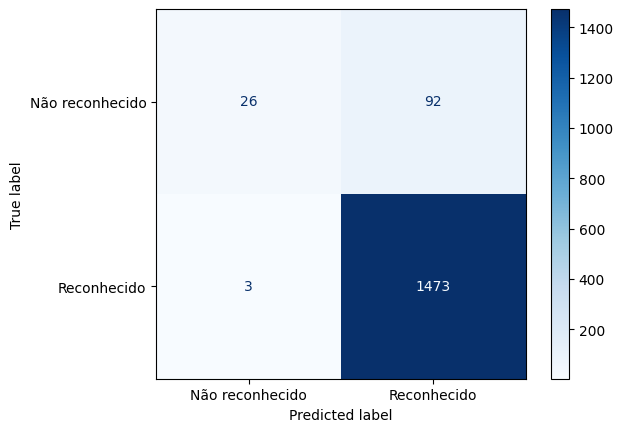

In [67]:
# Matriz de Confusão
ConfusionMatrixDisplay.from_estimator(best_rf_class_0_model, X_test_selected, y_test, values_format='d', cmap='Blues', display_labels=['Não reconhecido', 'Reconhecido'])

### Impotância > -0.00001



In [71]:
# Filtrar as variáveis com importância média > -0.00001
positive_idx = result.importances_mean > -0.00001

# Selecionar apenas as colunas das features com importância positiva
selected_features = X_test.columns[positive_idx]

# Criar novos datasets apenas com essas features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Exibir as features selecionadas
print('Número de Features:', len(selected_features))
print('Features selecionadas:', selected_features.tolist())

Número de Features: 109
Features selecionadas: ['DH_MORTOS', 'DH_FERIDOS', 'DH_ENFERMOS', 'DH_DESABRIGADOS', 'DH_DESALOJADOS', 'DH_DESAPARECIDOS', 'DH_OUTROS AFETADOS', 'DM_Uni Habita Danificadas', 'DM_Uni Habita Destruidas', 'DM_Uni Habita Valor', 'DM_Inst Saúde Danificadas', 'DM_Inst Saúde Destruidas', 'DM_Inst Saúde Valor', 'DM_Inst Ensino Danificadas', 'DM_Inst Ensino Valor', 'DM_Inst Serviços Danificadas', 'DM_Inst Serviços Destruidas', 'DM_Inst Serviços Valor', 'DM_Inst Comuni Danificadas', 'DM_Inst Comuni Destruidas', 'DM_Inst Comuni Valor', 'DM_Obras de Infra Danificadas', 'DM_Obras de Infra Destruidas', 'DM_Obras de Infra Valor', 'PEPL_Abast de água pot(R$)', 'PEPL_sist de esgotos sanit(R$)', 'PEPL_Sis cont pragas (R$)', 'PEPL_distrib energia (R$)', 'PEPL_Telecomunicações (R$)', 'PEPL_Tran loc/reg/l_curso (R$)', 'PEPL_Distrib combustíveis(R$)', 'PEPL_Segurança pública (R$)', 'PEPR_Agricultura (R$)', 'PEPR_Pecuária (R$)', 'DensidadePop', 'DOMICILIO_AREARURAL', 'PDEFAGUA', 'PDEF

In [72]:
# Treinamento

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'rf_class_0__criterion': ['gini', 'entropy'],
    'rf_class_0__n_estimators': [150, 175, 200, 225, 250, 300],
    'rf_class_0__max_depth': [2, 4, 6, 8],
    'rf_class_0__min_samples_split': [2, 5, 10, 15, 100],
    'rf_class_0__min_samples_leaf': [1, 2, 5, 10],
    'rf_class_0__max_features': ['sqrt', 'log2', None]
}

# Criar pipeline com RobustScaler e RandomForestClassifier
pipeline_rf_class_0 = Pipeline([
    ('scaler', RobustScaler()),
    ('rf_class_0', RandomForestClassifier(random_state = 42))
])

# Realizar a busca bayesiana com validação cruzada
bayes_search_rf_class_0 = BayesSearchCV(
    pipeline_rf_class_0,
    search_spaces = param_grid_bayes,
    n_iter = 30,
    cv = 5,
    scoring = 'f1_weighted',
    n_jobs = -1,
    random_state = 42
)

# Ajustar a busca bayesiana ao conjunto de treino
bayes_search_rf_class_0.fit(X_train_selected, y_train)

# Melhor modelo encontrado
best_rf_class_0_model = bayes_search_rf_class_0.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros: {bayes_search_rf_class_0.best_params_}")

# Fazer previsões com o conjunto de teste
y_pred_rf_class_0 = best_rf_class_0_model.predict(X_test_selected)

# Relatório de classificação TREINO
classification_report_rf_class_0 = metrics.classification_report(y_train, best_rf_class_0_model.predict(X_train_selected), digits = 6, target_names = ['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest [TREINO]: \n')
print(classification_report_rf_class_0)

# Relatório de classificação TESTE
classification_report_rf_class_0 = metrics.classification_report(y_test, y_pred_rf_class_0, digits = 6, target_names = ['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest [TESTE]: \n')
print(classification_report_rf_class_0)

Melhores hiperparâmetros: OrderedDict([('rf_class_0__criterion', 'gini'), ('rf_class_0__max_depth', 8), ('rf_class_0__max_features', None), ('rf_class_0__min_samples_leaf', 2), ('rf_class_0__min_samples_split', 2), ('rf_class_0__n_estimators', 300)])

 Classification report para Random Forest [TREINO]: 

                 precision    recall  f1-score   support

Não reconhecido   1.000000  0.262712  0.416107       472
    Reconhecido   0.944338  1.000000  0.971372      5904

       accuracy                       0.945420      6376
      macro avg   0.972169  0.631356  0.693740      6376
   weighted avg   0.948458  0.945420  0.930267      6376


 Classification report para Random Forest [TESTE]: 

                 precision    recall  f1-score   support

Não reconhecido   0.904762  0.161017  0.273381       118
    Reconhecido   0.937063  0.998645  0.966874      1476

       accuracy                       0.936637      1594
      macro avg   0.920912  0.579831  0.620128      1594
   weigh

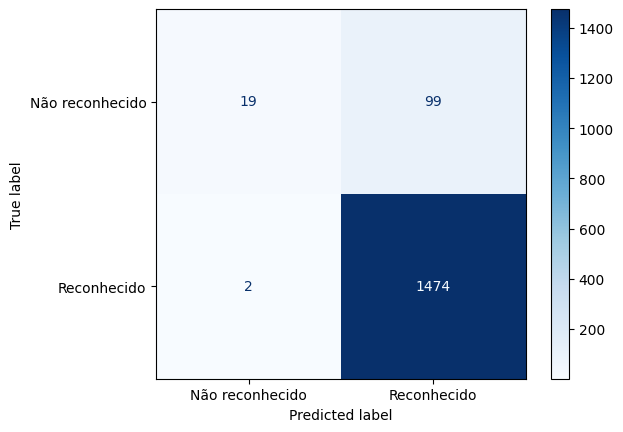

In [73]:
# Matriz de Confusão
ConfusionMatrixDisplay.from_estimator(best_rf_class_0_model, X_test_selected, y_test, values_format='d', cmap='Blues', display_labels=['Não reconhecido', 'Reconhecido'])

### Correlação < 0.5

In [74]:
# Calcular a matriz de correlação
corr_matrix = X_train.corr()

# Criar um dataframe para armazenar os pares com alta correlação
high_corr_pairs = set()

# Iterar pela matriz de correlação e encontrar pares com correlação acima de 0.5
threshold = 0.5
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) >= threshold:
            # Adicionar os pares de features com correlação maior que o threshold
            high_corr_pairs.add((corr_matrix.columns[i], corr_matrix.columns[j]))

# Exibir os pares com alta correlação
print(f'Pares de features com correlação maior que {threshold}:')
print(high_corr_pairs)

# Remover uma feature de cada par com alta correlação
features_to_remove = {pair[1] for pair in high_corr_pairs}  # Remover a segunda feature em cada par
X_train_uncorrelated = X_train.drop(columns = features_to_remove)
X_test_uncorrelated = X_test.drop(columns = features_to_remove)

# Exibir as features que foram removidas
print(f'Features removidas devido à alta correlação: {features_to_remove}')
print('Número de Features removidas:', len(features_to_remove))

Pares de features com correlação maior que 0.5:
{('DM_Inst Saúde Valor', 'DH_DESALOJADOS'), ('PEPL_Segurança pública (R$)', 'DM_Inst Serviços Valor'), ('PEPL_Segurança pública (R$)', 'PEPL_Telecomunicações (R$)'), ('PEPL_Segurança pública (R$)', 'PEPL_Tran loc/reg/l_curso (R$)'), ('PEPL_Segurança pública (R$)', 'DM_Uni Habita Valor'), ('PEPL_Tran loc/reg/l_curso (R$)', 'DM_Inst Comuni Valor'), ('PEPL_Segurança pública (R$)', 'PEPL_Sis cont pragas (R$)'), ('PEPL_Sis cont pragas (R$)', 'PEPL_sist de esgotos sanit(R$)'), ('PEPL_Sis limp e rec lixo (R$)', 'DM_Inst Ensino Valor'), ('PDEFAGUA', 'DOMICILIO_AREARURAL'), ('PEPL_Telecomunicações (R$)', 'DM_Uni Habita Valor'), ('PEPR_Indústria (R$)', 'DH_MORTOS'), ('PEPL_Telecomunicações (R$)', 'PEPL_Sis cont pragas (R$)'), ('PDEFSAN', 'DOMICILIO_AREARURAL'), ('PDEFLIXO', 'DOMICILIO_AREARURAL'), ('PEPL_sist de esgotos sanit(R$)', 'DM_Inst Comuni Valor'), ('DM_Inst Ensino Valor', 'DM_Inst Ensino Danificadas'), ('PEPL_Tran loc/reg/l_curso (R$)', 'P

In [75]:
# Treinamento

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'rf_class_0__criterion': ['gini', 'entropy'],
    'rf_class_0__n_estimators': [150, 175, 200, 225, 250, 300],
    'rf_class_0__max_depth': [2, 4, 6, 8],
    'rf_class_0__min_samples_split': [2, 5, 10, 15, 100],
    'rf_class_0__min_samples_leaf': [1, 2, 5, 10],
    'rf_class_0__max_features': ['sqrt', 'log2', None]
}

# Criar pipeline com RobustScaler e RandomForestClassifier
pipeline_rf_class_0 = Pipeline([
    ('scaler', RobustScaler()),
    ('rf_class_0', RandomForestClassifier(random_state = 42))
])

# Realizar a busca bayesiana com validação cruzada
bayes_search_rf_class_0 = BayesSearchCV(
    pipeline_rf_class_0,
    search_spaces = param_grid_bayes,
    n_iter = 30,
    cv = 5,
    scoring = 'f1_weighted',
    n_jobs = -1,
    random_state = 42
)

# Ajustar a busca bayesiana ao conjunto de treino
bayes_search_rf_class_0.fit(X_train_uncorrelated, y_train)

# Melhor modelo encontrado
best_rf_class_0_model = bayes_search_rf_class_0.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros: {bayes_search_rf_class_0.best_params_}")

# Fazer previsões com o conjunto de teste
y_pred_rf_class_0 = best_rf_class_0_model.predict(X_test_uncorrelated)

# Relatório de classificação TREINO
classification_report_rf_class_0 = metrics.classification_report(y_train, best_rf_class_0_model.predict(X_train_uncorrelated), digits = 6, target_names = ['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest [TREINO]: \n')
print(classification_report_rf_class_0)

# Relatório de classificação TESTE
classification_report_rf_class_0 = metrics.classification_report(y_test, y_pred_rf_class_0, digits = 6, target_names = ['Não reconhecido', 'Reconhecido'])
print('\n Classification report para Random Forest [TESTE]: \n')
print(classification_report_rf_class_0)

Melhores hiperparâmetros: OrderedDict([('rf_class_0__criterion', 'gini'), ('rf_class_0__max_depth', 8), ('rf_class_0__max_features', None), ('rf_class_0__min_samples_leaf', 2), ('rf_class_0__min_samples_split', 2), ('rf_class_0__n_estimators', 150)])

 Classification report para Random Forest [TREINO]: 

                 precision    recall  f1-score   support

Não reconhecido   0.991803  0.256356  0.407407       472
    Reconhecido   0.943876  0.999831  0.971048      5904

       accuracy                       0.944793      6376
      macro avg   0.967840  0.628093  0.689228      6376
   weighted avg   0.947424  0.944793  0.929323      6376


 Classification report para Random Forest [TESTE]: 

                 precision    recall  f1-score   support

Não reconhecido   0.478261  0.093220  0.156028       118
    Reconhecido   0.931891  0.991870  0.960945      1476

       accuracy                       0.925345      1594
      macro avg   0.705076  0.542545  0.558487      1594
   weigh

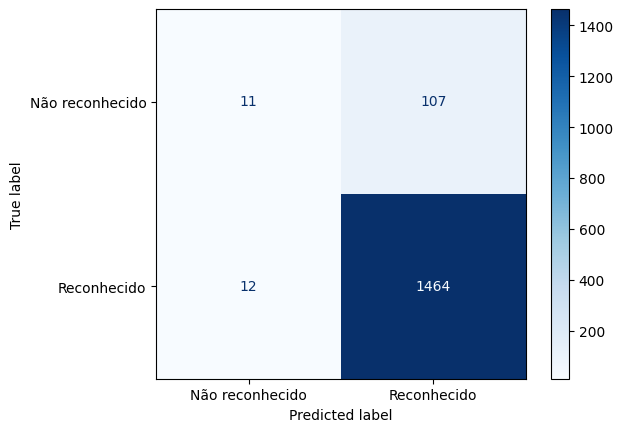

In [76]:
# Matriz de Confusão
ConfusionMatrixDisplay.from_estimator(best_rf_class_0_model, X_test_uncorrelated, y_test, values_format='d', cmap='Blues', display_labels=['Não reconhecido', 'Reconhecido'])